In [58]:
import pandas as pd
import xarray as xr
import numpy as np
import zarr
import gcsfs
import dask
import dask.array
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import cv2 as cv
from skimage import metrics
from IPython.display import HTML

# Set matplotlib defaults.
matplotlib.rc('figure', figsize=(15, 15))
CMAP = 'gray'
matplotlib.rc('image', cmap=CMAP)

# Load satellite data

The geostationary satellite data originates from EUMETSAT.  We use data from the [SEVIRI Rapid Scan High Rate instrument](https://navigator.eumetsat.int/product/EO:EUM:DAT:MSG:MSG15-RSS).  This instrument takes an image every 5 minutes of the top third of the planet.  We converted the native EUMETSAT data to [Zarr](https://zarr.readthedocs.io/) (we're very impressed with Zarr!  It's great for storing dense n-dimensional arrays in the cloud or on a local workstation.  We hope to publicly release this processed EUMETSAT data soon!)

In [2]:
ZARR = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/OSGB36/all_zarr_int16'
gcs = gcsfs.GCSFileSystem()
store = gcsfs.GCSMap(root=ZARR, gcs=gcs)

Lazily open the Zarr array.  (The entire dataset is about 1.5 TBytes uncompressed.  Zarr combined with dask and xarray allows us to process this large dataset in chunks, so we don't need 1.5 TB of RAM!)

In [3]:
%%time
dataset = xr.open_zarr(store, consolidated=True)

CPU times: user 3.48 s, sys: 377 ms, total: 3.85 s
Wall time: 2min 54s


The dataset contains a single array called stacked_eumetset_data with four dimensions: `time, y, x, channel`.  We want just the first satellite channel for this experiment.  This is the 'high resolution visible' (HRV) channel.

In [4]:
source_array = dataset['stacked_eumetsat_data'][..., 0]

To minimise disk space (and maximise read performance) whilst maximising numerical precision, we store the data as signed 16-bit integers.  `-1` represents a missing value, so we replace all `-1` values with NaNs.

In [6]:
source_array = source_array.astype(np.float32)
condition = source_array != -1
source_array = source_array.where(cond=condition, other=np.NaN)

OpenCV's optical flow methods expect uint8 single-channel images, so we need to convert from 10-bit ints (in the range [0, 1023]) to 8-bit.

In [7]:
MIN = 0
MAX = 1023

source_array -= MIN
source_array /= (MAX - MIN)
source_array *= 255
source_array = source_array.astype(np.uint8)

At this point, we haven't actually loaded any data into memory!  Let's load a handful of images into RAM:

In [8]:
%%time

# Number of images *before* our prediciton start.
NUM_WARM_UP_IMAGES = 6

# Number of timesteps to predict into the future.
NUM_PREDICTION_TIMESTEPS = 24

START_I = 3000
END_I = START_I + NUM_WARM_UP_IMAGES + NUM_PREDICTION_TIMESTEPS
images = source_array[START_I:END_I].compute()

CPU times: user 630 ms, sys: 168 ms, total: 797 ms
Wall time: 908 ms


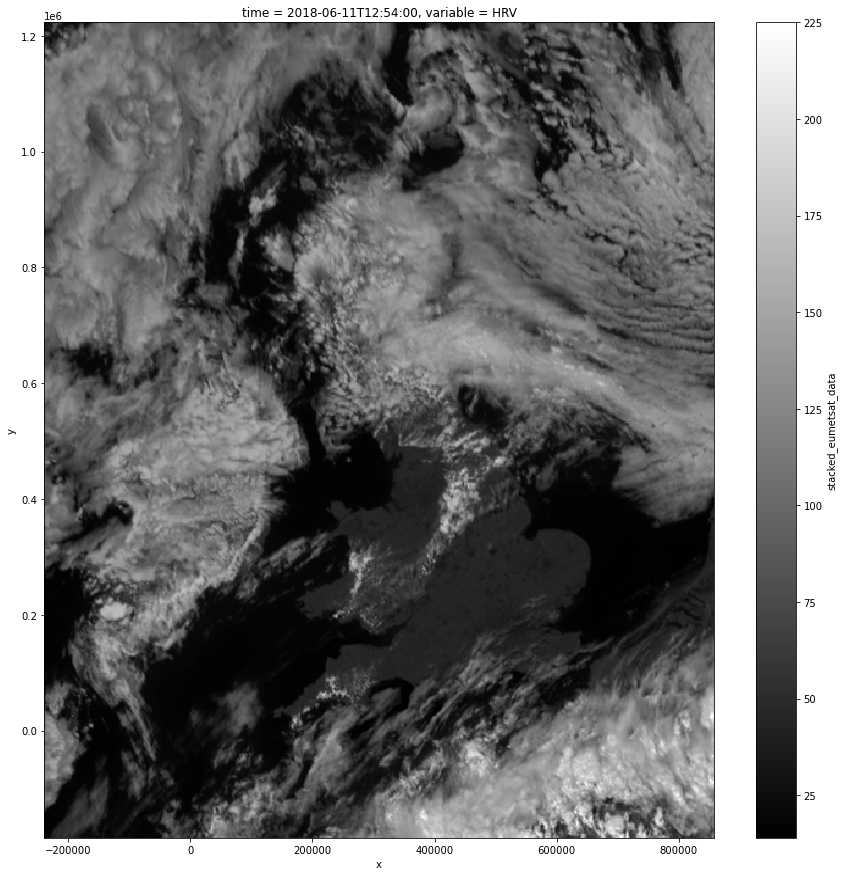

In [15]:
images[0].plot(cmap=CMAP);

# Compute optical flow

* Adapted from [OpenCV Python Tutorials](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html#dense-optical-flow-in-opencv).
* [OpenCV API document for calcOpticalFlowFarneback](https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowfarneback).

The `calcOpticalFlowFarneback` function takes two images and computes the dense optical flow field.  The output is a numpy array with three dimensions.  The first two dimensions are the image width and height from the source image.  The last dimension is of size two and represents the x and y displacements.

We compute the optical flow field for each pair of consecutive 'warm up' images, so we can take the weighted mean of these flow fields (which appears to improve prediction skill).

In [74]:
def compute_flows(**kwargs):
    flows = []
    for image_i in range(NUM_WARM_UP_IMAGES):
        flow = cv.calcOpticalFlowFarneback(
            prev=images[image_i].values, next=images[image_i+1].values, flow=None, **kwargs)
        flows.append(flow)
    return np.stack(flows).astype(np.float32)

First, use the default parameters for `calcOpticalFlowFarneback`.

In [75]:
%%time
flows_default = compute_flows(
    pyr_scale=0.5, levels=3, winsize=15, 
    iterations=10, poly_n=5, poly_sigma=1.2, 
    flags=cv.OPTFLOW_FARNEBACK_GAUSSIAN)

CPU times: user 2.46 s, sys: 12.2 ms, total: 2.48 s
Wall time: 1.77 s


Now compute flows using parameters optimised using a clunky semi-manual search (the code for which is at the end of this notebook!)

In [76]:
%%time
flows_optimised = compute_flows(
    pyr_scale=0.5, levels=2, winsize=40, iterations=3, 
    poly_n=5, poly_sigma=0.7, flags=cv.OPTFLOW_FARNEBACK_GAUSSIAN)

CPU times: user 1.74 s, sys: 8.76 ms, total: 1.75 s
Wall time: 1.04 s


Take the mean

In [82]:
def weighted_average(flows):
    return np.average(flows, axis=0, weights=range(1, NUM_WARM_UP_IMAGES+1)).astype(np.float32)

flow_optimised = weighted_average(flows_optimised)

In [83]:
flow_default = weighted_average(flows_default)

## Plot optical flow

Adapted from [OpenCV Python Tutorials](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html#dense-optical-flow-in-opencv).

The angle (direction) of the optical flow field is represented by image hue; and the distance (magnitude) of flow is represented by the value of HSV color representation. The strength of HSV is always set to a maximum of 255 for optimal visibility.

In [54]:
def plot_flow_vectors(flow):
    # Computes the magnitude and angle of the 2D vectors 
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])

    # Creates an image filled with zero 
    # intensities with the same dimensions  
    # as the frame 
    hsv_shape = images[0].shape + (3,)
    hsv = np.zeros(shape=hsv_shape, dtype=np.uint8) 

    # Sets image hue according to the optical flow  
    # direction 
    hsv[..., 0] = angle * 180 / np.pi / 2

    # Sets image saturation to maximum 
    hsv[..., 1] = 255

    # Sets image value according to the optical flow 
    # magnitude (normalized) 
    hsv[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
    
    # Converts HSV to RGB (BGR) color representation 
    rgb = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    
    fig, axes = plt.subplots(figsize=(20, 10), ncols=3)
    axes[0].set_title('Optical flow field')
    axes[0].imshow(rgb)
    axes[1].set_title('image 0')
    axes[1].imshow(images[0])
    axes[2].set_title(f'image {NUM_WARM_UP_IMAGES}')
    axes[2].imshow(images[NUM_WARM_UP_IMAGES])

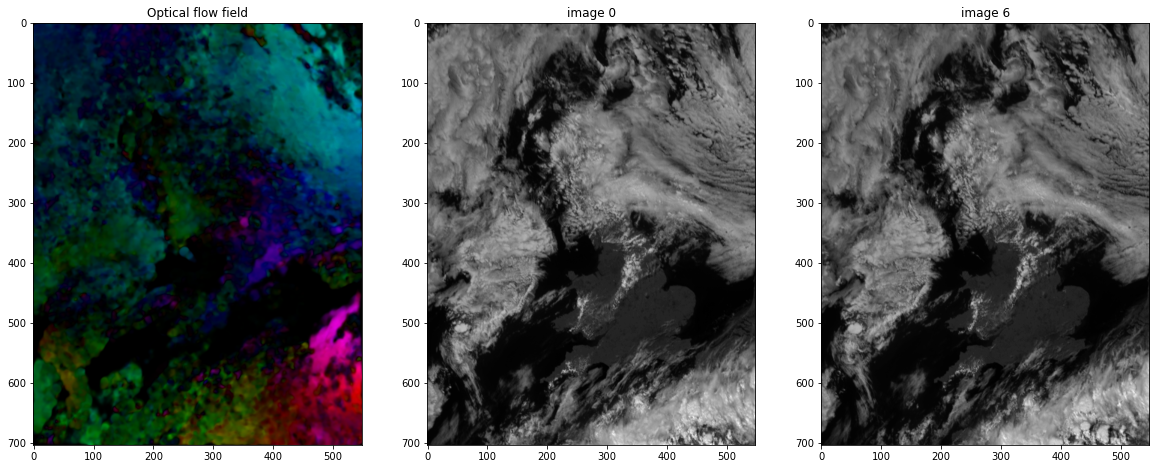

In [55]:
plot_flow_vectors(flow_default)

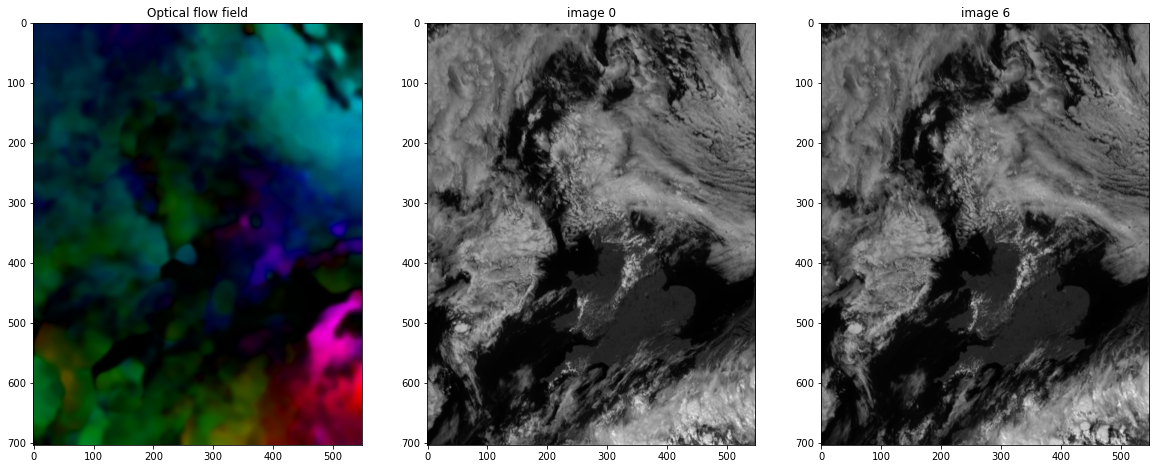

In [56]:
plot_flow_vectors(flow_optimised)

# Use optical flow to project image forwards in time

In [57]:
def remap_image(image: np.ndarray, flow: np.ndarray) -> np.ndarray:
    """Takes an image and warps it forwards in time according to the flow field.
    
    Args:
        image: The grayscale image to warp.
        flow: A 3D array.  The first two dimensions must be the same size as the first two
            dimensions of the image.  The third dimension represented the x and y displacement.
            
    Returns:  Warped image.
    """
    # Adapted from https://github.com/opencv/opencv/issues/11068
    height, width = flow.shape[:2]
    remap = -flow.copy()
    remap[..., 0] += np.arange(width)  # x map
    remap[..., 1] += np.arange(height)[:, np.newaxis]  # y map
    return cv.remap(src=image, map1=remap, map2=None, interpolation=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)

Create animation :)

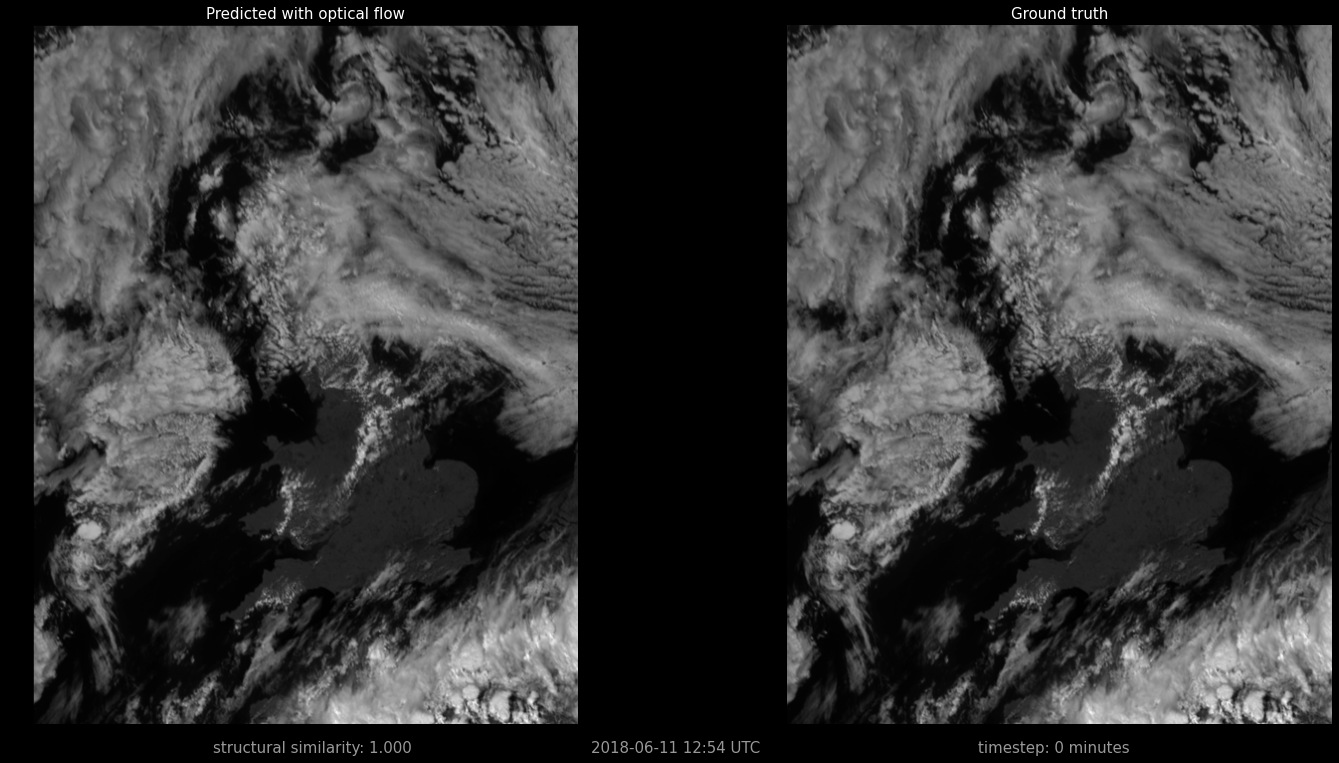

In [142]:
fig, axes = plt.subplots(
    figsize=(19.20, 10.80), # moviewriter doesn't listen to the width, just the height
    ncols=2)
fig.patch.set_facecolor('black')
fig.subplots_adjust(left=0, bottom=0.05, right=1, top=0.95, wspace=None, hspace=None)

axes[0].set_title('Predicted with optical flow', color='white', fontsize=15)
image_t0 = images[NUM_WARM_UP_IMAGES].values
axes_0_image = axes[0].imshow(image_t0)
axes[1].set_title('Ground truth', color='white', fontsize=15)
axes_1_image = axes[1].imshow(image_t0)


TEXT_CONFIG = dict(alpha=0.6, linespacing=1.5, color='white', fontsize=15, 
    verticalalignment='top', horizontalalignment='left', y=720)

iteration_text = axes[0].text(x=950, s='timestep: 0 minutes', **TEXT_CONFIG)

dt_text = axes[0].text(
    x=560, s=pd.Timestamp(images[0]['time'].values).strftime('%Y-%m-%d %H:%M UTC'), **TEXT_CONFIG)

ssim_text = axes[0].text(
    x=180, s='structural similarity: 1.000', **TEXT_CONFIG)

def update(i):
    remapped_image = remap_image(image_t0, flow_optimised * i)
    axes_0_image.set_data(remapped_image)
    ground_truth_image = images[NUM_WARM_UP_IMAGES+i]
    axes_1_image.set_data(ground_truth_image)
    iteration_text.set_text(f'timestep: {i*5:03d} minutes')
    ssim = metrics.structural_similarity(ground_truth_image, remapped_image)
    ssim_text.set_text(f'structural similarity: {ssim:.3f}')
    dt = pd.Timestamp(ground_truth_image['time'].values)
    dt_text.set_text(dt.strftime('%Y-%m-%d %H:%M UTC'))
    
plt.axis('off')
anim = animation.FuncAnimation(fig, update, frames=NUM_PREDICTION_TIMESTEPS, interval=120)

In [144]:
HTML(anim.to_html5_video())

In [143]:
# Docs: https://matplotlib.org/3.1.1/api/animation_api.html#writer-classes
metadata = dict(title='Optical flow for predicting movement of clouds over UK', artist='Open Climate Fix')
moviewriter = animation.FFMpegFileWriter(fps=12, bitrate=100000, metadata=metadata)

with moviewriter.saving(fig, 'optical_flow.mp4', dpi=100):
    for i in range(NUM_PREDICTION_TIMESTEPS):
        update(i)
        moviewriter.grab_frame() 

# Compute Structural Similarity score

In [92]:
scores = pd.DataFrame(
    columns=[
        'persistence', 'optical flow default weighted av', 'optical flow optimised weighted av', 'optical flow optimised av',
        'optical flow optimised last'], 
    index=np.arange(NUM_PREDICTION_TIMESTEPS) * 5)

for i in range(NUM_PREDICTION_TIMESTEPS):
    ground_truth_image = images[NUM_WARM_UP_IMAGES+i]
    timestep = i * 5
    scores['persistence'][timestep] = metrics.structural_similarity(
        image_t0, ground_truth_image)
    scores['optical flow default weighted av'][timestep] = metrics.structural_similarity(
        ground_truth_image, remap_image(image_t0, flow_default * i))
    scores['optical flow optimised weighted av'][timestep] = metrics.structural_similarity(
        ground_truth_image, remap_image(image_t0, flow_optimised * i))
    scores['optical flow optimised av'][timestep] = metrics.structural_similarity(
        ground_truth_image, remap_image(image_t0, np.mean(flows_optimised, axis=0) * i))
    scores['optical flow optimised last'][timestep] = metrics.structural_similarity(
        ground_truth_image, remap_image(image_t0, flows_optimised[-1] * i))

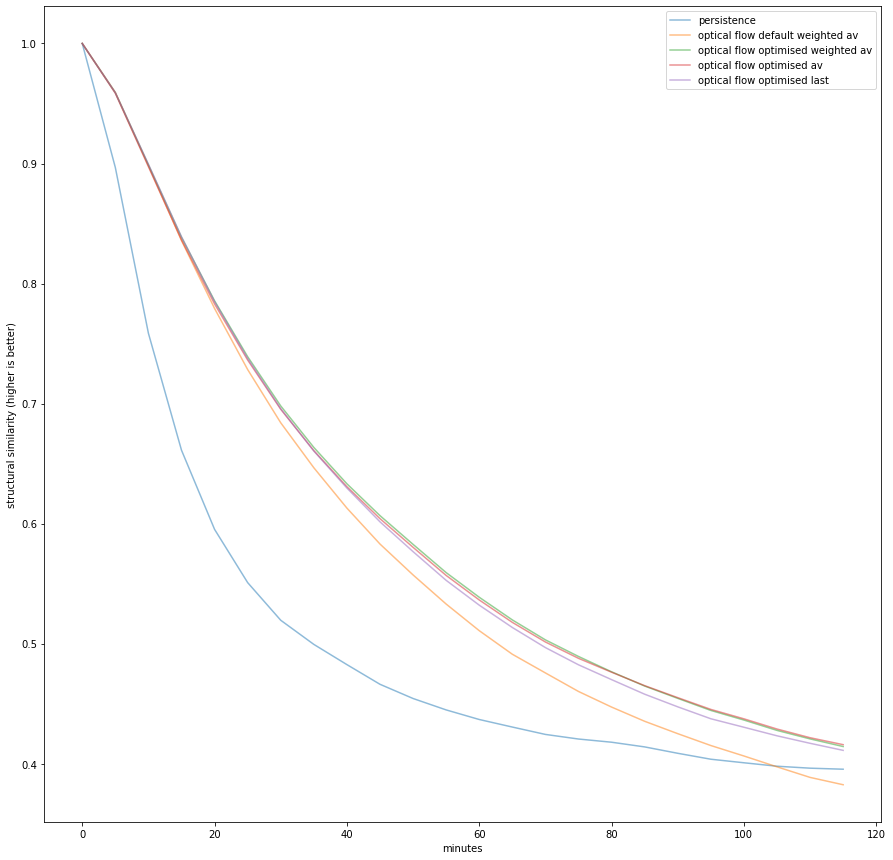

In [95]:
ax = scores.plot(alpha=0.5)
ax.set_ylabel('structural similarity (higher is better)')
ax.set_xlabel('minutes');

# Search over params for optical flow

Hacky search over params for optical flow :)

In [101]:
def compute_opt_flow_and_score(pyr_scale=0.5, levels=3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, flags=cv.OPTFLOW_FARNEBACK_GAUSSIAN):
    flow = cv.calcOpticalFlowFarneback(
        prev=images[0].values, next=images[1].values, flow=None, 
        pyr_scale=pyr_scale, levels=levels, winsize=winsize, iterations=iterations, 
        poly_n=poly_n, poly_sigma=poly_sigma, flags=flags)
    
    num_timesteps = 23
    ss_scores = []
    for i in range(1, num_timesteps):
        predicted_image = remap_image(images[1].values, flow * i, cv.INTER_LINEAR)
        score = metrics.structural_similarity(images[i+1], predicted_image)
        ss_scores.append(score)
        
    return ss_scores

In [131]:
from copy import deepcopy
import time

In [195]:
param_defaults = dict(
    pyr_scale=0.5, 
    levels=2, 
    winsize=40, 
    iterations=3, 
    poly_n=5, 
    poly_sigma=0.7, 
    flags=cv.OPTFLOW_FARNEBACK_GAUSSIAN)

param_ranges = dict(
    pyr_scale=np.arange(0.1, 1, 0.1), 
    levels=np.arange(1, 10), 
    winsize=[5, 35, 37, 40, 42, 45, 50, 60], 
    iterations=[1, 3, 5, 10, 20, 50], 
    poly_n=[1, 2, 3, 5, 9], 
    poly_sigma=[0.1, 0.5, 0.6, 0.7, 1, 1.1, 1.2, 1.9], 
    flags=[cv.OPTFLOW_FARNEBACK_GAUSSIAN])

In [182]:
all_scores = {}
durations = {}
for param_name, param_values in param_ranges.items():
    print(param_name, param_values)
    params_to_pass = deepcopy(param_defaults)
    for val in param_values:
        params_to_pass[param_name] = val
        t0 = time.time()
        scores = compute_opt_flow_and_score(**params_to_pass)
        t1 = time.time()
        key = (param_name, val)
        all_scores[key] = np.mean(scores)
        durations[key] = t1 - t0

pyr_scale [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
levels [1 2 3 4 5 6 7 8 9]
winsize [5, 35, 37, 40, 42, 45, 50, 60]
iterations [1, 3, 5, 10, 20, 50]
poly_n [1, 2, 3, 5, 9]
poly_sigma [0.1, 0.5, 0.6, 0.7, 1, 1.1, 1.2, 1.9]
flags [256]


In [183]:
all_scores = pd.Series(all_scores)

for param_name in param_ranges.keys():
    print(param_name, all_scores[param_name].idxmax())

pyr_scale 0.1
levels 1.0
winsize 40.0
iterations 1.0
poly_n 2.0
poly_sigma 0.7
flags 256.0


<AxesSubplot:>

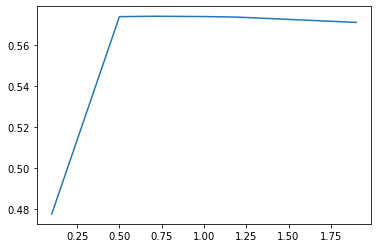

In [193]:
param_name = 'poly_sigma'
all_scores[param_name].plot()

In [194]:
all_scores[param_name]

0.1    0.477795
0.5    0.573649
0.6    0.573737
0.7    0.573845
1.0    0.573691
1.1    0.573573
1.2    0.573412
1.9    0.570852
dtype: float64

In [169]:
durations

{('pyr_scale', 0.1): 1.0047938823699951,
 ('pyr_scale', 0.2): 0.998220682144165,
 ('pyr_scale', 0.30000000000000004): 1.009876012802124,
 ('pyr_scale', 0.4): 1.0129318237304688,
 ('pyr_scale', 0.5): 1.029860258102417,
 ('pyr_scale', 0.6): 1.0669550895690918,
 ('pyr_scale', 0.7000000000000001): 1.0969767570495605,
 ('pyr_scale', 0.8): 1.1445612907409668,
 ('pyr_scale', 0.9): 1.1860337257385254,
 ('levels', 1): 1.0653572082519531,
 ('levels', 2): 1.0750412940979004,
 ('levels', 3): 1.0825397968292236,
 ('levels', 4): 1.1304538249969482,
 ('levels', 5): 1.0996029376983643,
 ('levels', 6): 1.1152970790863037,
 ('levels', 7): 1.1078686714172363,
 ('levels', 8): 1.110304355621338,
 ('levels', 9): 1.108097791671753,
 ('winsize', 5): 1.018218994140625,
 ('winsize', 25): 1.008971929550171,
 ('winsize', 35): 1.0310568809509277,
 ('winsize', 40): 1.0507981777191162,
 ('winsize', 45): 1.056105136871338,
 ('winsize', 50): 1.037574052810669,
 ('winsize', 60): 1.0565359592437744,
 ('winsize', 75): 1.